# Wolff Algorithm and Broad Histogram method for 3D Heisenberg Model

## Packages

In [1]:
try:
    from tqdm.notebook import tqdm as tq
except:
    !pip install tqdm
    from tqdm.notebook import tqdm as tq

import numpy as np
from scipy import integrate
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numba as nb
import seaborn as sns
import pandas as pd
from numba import prange
import time as tm
from tqdm.notebook import tqdm as tq

from scipy.optimize import curve_fit

rcParams.update({'font.size': 11.5})

# General functions

## Initilization and neighbors

In [2]:
def gaussian(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/sigma**2)

@nb.njit
def random_initialize(L):
    """Generates a random initialization of the spins lattice.
    Args:
        L (int): Length of the lattice
    Returns:
        S (array): (L^3 x 3) array where each row represents a spin and each column contains
                    its components in x, y and z.
    """
    N = L**3
    S = np.zeros((N,3))
    PHI = np.random.uniform(0, 2*np.pi, N)
    THETA = np.random.uniform(0, np.pi, N)
    Sx = np.sin(THETA)*np.cos(PHI)
    Sy = np.sin(THETA)*np.sin(PHI)
    Sz = np.cos(THETA)
    S[:,0], S[:,1], S[:,2] = Sx, Sy, Sz 
    return S

@nb.njit
def get_neighbors(L):
    """
    Args:
        L (int): Length of the lattice
    Returns:
        nbr (array): (L^3 x 6) array where each row represents a spin and each column the
                    the index of its neighbors.
    """
    N = L**3
    nbr = np.zeros((N,6),dtype=np.int32)
    for i in range(N):
        nbr[i,:] = [(i // L) * L + (i - 1) % L, (i // L) * L + (i + 1) % L,
               (i + L) % N, (i - L) % N, (i + L**2) % N, (i - L**2) % N]
    return nbr

def central_diff(Y, dx):
    n = Y.shape[0]
    dy_dx = np.zeros(n-2)
    for i in range(n-2):
        dy_dx[i] = (Y[i+2]-Y[i])/(2*dx)
    return dy_dx

In [3]:
@nb.njit
def Metropolis(S, nbr, T, n_flips):
    N = S.shape[0]
    for step in range(n_flips):       
        # Random vector r
        phi = np.random.uniform(0, 2*np.pi)
        z = np.random.uniform(-1,1)
        theta = np.arccos(z)
        r = np.array([np.sin(theta)*np.cos(phi),
                      np.sin(theta)*np.sin(phi),
                      np.cos(theta)])
        
        # Generate and flip cluster at site k
        k = np.random.randint(0, N)
        A_k = np.sum(S[nbr[k]],axis=0)
        Anorm = np.linalg.norm(A_k)
        S_k = S[k]
        # Calculate the old and new energy (assumin the flip is accepted):
        ek_old = -np.dot(S_k, A_k)
        S_k = S_k - 2*np.dot(S_k, r)*r
        ek_new = -np.dot(S_k, A_k)
        DeltaE = ek_new - ek_old
        p = np.exp(-DeltaE/T) # Probability of accepting the move
        if np.random.random() < p:
            S[k] = S_k # Accept the move with probability p
    return S

## Thermodynamic quantities

In [4]:
@nb.njit
def calculate_energy(S, nbr):
    """
    Args:
        S (array): Lattice
        nbr (array): Neighbors
    Returns:
        E (float): Energy
    """
    N = S.shape[0]
    E = 0
    for i in prange(N):
        nbrs_i = nbr[i]
        S_i = S[i]
        for ii in nbrs_i:
            E += -np.dot(S[ii], S_i)
    E = E/2
    return E

@nb.njit
def calculate_magnet(S):
    """
    Args:
        S (array): Lattice
    Returns:
        M (float): Magentization calculated as the norm of the sum of all spin vectors
    """
    N = S.shape[0]
    S_sum = np.sum(S, axis=0)
    return 1/N*np.linalg.norm(S_sum)

In [5]:
def test_calculate_energy(L):
    nbr = get_neighbors(L)
    S = random_initialize(L)
    E = calculate_energy(S, nbr)
    print('Energy1 = ', E)
    S = np.zeros((L**3,3))
    S[:,0] = 1
    E = calculate_energy(S, nbr)
    print('Energy2 =', E)

test_calculate_energy(10)

Energy1 =  -8.728721800917123
Energy2 = -3000.0


# Wolff Clusters Algorithm

In [6]:
@nb.njit
def p_acc(T, r, s_i, s_j):
    """
    Args:
        T (float): Temperature
        r (array): Random vector along which the cluster will be flipped
        s_i (array): Spin i
        s_j (array): Spin j (neighbor to add/reject)
    Returns:
        p (float): Probability of accepting a neighboring spin in the cluster
    """
    beta = 1/T
    p = 1-np.exp(min(0,-2*beta*(np.dot(r, s_i))*np.dot(r, s_j))) 
    return p

@nb.njit
def add_neighbors(neighbors, j, T, r, S, Pocket, Cluster):
    """
    Args:
        T (float): Temperature
        r (array): Random vector along which the cluster will be flipped
        s_i (array): Spin i
        s_j (array): Spin j (neighbor to add/reject)
    Returns:
        p (float): Probability of accepting a neighboring spin in the cluster
    """
    for ii in range(neighbors[j].shape[0]):
        l = int(neighbors[j][ii])
        p = p_acc(T, r, S[j,:], S[l,:])
        if (l not in Cluster) and np.random.random() < p:
            Pocket = np.append(Pocket, l)
            Cluster = np.append(Cluster, l)
    return Pocket, Cluster

@nb.njit
def generate_and_flip_cluster(S, neighbors, k, T, r):
    Pocket, Cluster = np.array([k], dtype=np.int32), np.array([k], dtype=np.int32)
    while Pocket.shape[0] != 0:
        index_j = np.random.randint(0, Pocket.shape[0])
        j = int(Pocket[index_j])
        Pocket, Cluster = add_neighbors(neighbors, j, T, r, S, Pocket, Cluster)
        Pocket = np.delete(Pocket, index_j)
    for i in Cluster:
        S[i] = S[i] - 2*np.dot(S[i], r)*r
    return S

@nb.njit
def cluster_sample(S, nbr, T, n_flips):
    """
    Returns:
        S, E, M
    """
    N = S.shape[0] # Total number of spins
    # Generate cluster configuration with n_flips
    for step in range(n_flips):       
        # Random vector r
        phi = np.random.uniform(0, 2*np.pi)
        z = np.random.uniform(-1,1)
        theta = np.arccos(z)
        r = np.array([np.sin(theta)*np.cos(phi),
                      np.sin(theta)*np.sin(phi),
                      np.cos(theta)])
        
        # Generate and flip cluster at site k
        k = np.random.randint(0, N)
        S = generate_and_flip_cluster(S, nbr, k, T, r)
    E = calculate_energy(S, nbr)
    M = calculate_magnet(S)
    return S, E, M

In [7]:
@nb.njit
def thermo_T(S, nbr, T, n_samples):
    """Calculates the thermodynamic quantities at a given temperature
    Args:
        S (array)
        nbr (array)
        T (float): Temperature > 0
        n_samples (int): Number of values to calculate
        
    Returns:
        S (array)
        M (float): Magnetization
        Cv (float): Heat capacity
        Xm (float): Magnetic Susceptibility
    """
    M, M2 = 0, 0
    E, E2 = 0, 0
    n_flips = 10
    N = S.shape[0]
    for i in range(n_samples):
        S, E_current, M_current = cluster_sample(S, nbr, T, n_flips)
        E += E_current
        E2 += E_current**2
        M += M_current
        M2 += M_current**2
    M = M/n_samples
    Xm = (M2/n_samples - M**2)/T
    Cv = (E2/n_samples - (E/n_samples)**2)/(N*T**2)
    return S, E_current, (M, Cv, Xm)

In [8]:
n_temps = 30 # Number of temperature values 
T_vals = np.linspace(1.8, 1.2, n_temps)
Thermo_W = np.zeros((n_temps, 3))
L = 10
S = random_initialize(L)
nbr = get_neighbors(L)
t = tq(range(n_temps))
n_samples = 15000 # Number n of samples for calculating the thermal average
for ii in t:
    S, _, _  = cluster_sample(S, nbr, T_vals[ii], 2000) # First thermalize to desired temp.
    S, E, Thermo_W[ii, :] = thermo_T(S, nbr, T_vals[ii], n_samples)
    t.set_description("T = {:.3f} : ".format(T_vals[ii]))

  0%|          | 0/30 [00:00<?, ?it/s]

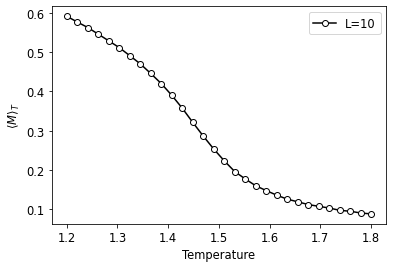

In [9]:
plt.plot(T_vals, Thermo_W[:,0],'ko-',mfc='w',label='L={}'.format(L))
plt.xlabel('Temperature')
plt.ylabel(r'$\langle M\rangle_T$')
plt.legend()
# plt.savefig('L_{}.jpg'.format(L), bbox_inches='tight')

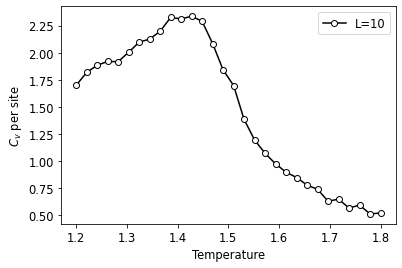

In [10]:
plt.plot(T_vals, Thermo_W[:,1],'ko-',mfc='w',label='L={}'.format(L))
plt.xlabel('Temperature')
plt.ylabel(r'$C_v$ per site')
plt.legend()

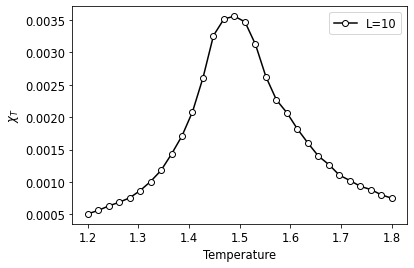

In [11]:
plt.plot(T_vals, Thermo_W[:,2],'ko-',mfc='w',label='L={}'.format(L))
plt.xlabel('Temperature')
plt.ylabel(r'$\chi_T$')
plt.legend()

# Broad Histogram Method

## Energize and rotate spin

In [12]:
@nb.njit
def get_angles(vector):
    """
    Args:
        vector (array)
        
    Returns:
        theta (float): Polar angle (z axis) 
        phi (float): Azimuth angle
    """
    r = np.linalg.norm(vector)
    x, y, z = vector[0], vector[1], vector[2]
    theta = np.arccos(z/r)
    if theta == 0:
        phi = 0
    else:
        phi = np.arccos(x/(r*np.sin(theta)))
        phi = np.arctan2(y,x)
    return theta, phi

In [13]:
def energize(S, nbr, E_target, tol, max_iter):
    """
    Args:
        S (array)
        nbr (array)
        E_target (float)
        tol (float)
        max_iter (int)
    Returns:
        S (array): Energized configuration
        E_current: Energy 
    """
    N = S.shape[0]
    iteration = 0
    E_current = calculate_energy(S, nbr)
    DeltaE = abs(E_target - E_current)
    while DeltaE > tol and iteration <= max_iter:
        # Choose a spin at random
        k = np.random.randint(0, N)
        S_k = S[k]
        # Calculate the local field of that spin
        A_k = np.sum(S[nbr[k]],axis=0)
        Anorm = np.linalg.norm(A_k)
        theta, phi = get_angles(A_k)
        # Make a rotation to align A_k with the z axis
        alpha = np.pi/2 - phi
        beta = -theta
        Rotz = np.array([[np.cos(alpha), -np.sin(alpha), 0],
                        [np.sin(alpha), np.cos(alpha), 0],
                        [0, 0, 1]])
        Rotx = np.array([[1, 0, 0],
                        [0, np.cos(beta), np.sin(beta)],
                        [0, -np.sin(beta), np.cos(beta)]])
        Rot = np.dot(Rotx, Rotz)
        # Calculates the old energy
        ei_old = -np.dot(S_k, A_k)
        z = -ei_old/Anorm
        if E_current < E_target:
            z = np.random.uniform(-1, z)
        else:
            z = np.random.uniform(z, 1)
        theta = np.arccos(z)
        phi = np.random.uniform(0, 2*np.pi)
        # Get the new vector in spherical coordinates
        Sk_new = np.array([[np.sin(theta)*np.cos(phi)],
                           [np.sin(theta)*np.sin(phi)],
                           [np.cos(theta)]])
        # Rotate the new vector back to the original basis
        Sk_new = np.reshape(np.dot(Rot.T, Sk_new), A_k.shape)
        ei_new = - np.dot(Sk_new, A_k)
        S[k] = Sk_new
        DE = ei_new - ei_old
        # Calculate the new energy
        E_current += DE
        DeltaE = abs(E_target-E_current)
        iteration += 1
    return S, E_current

In [14]:
def test_energize(L, tol=0.01):
    print('Tolerance is ', tol)
    print('................................')
    for i in range(5):
        S = random_initialize(L)
        nbr = get_neighbors(L)
        E_desired = np.random.uniform(-L**3, L**3)
        E_before = calculate_energy(S, nbr)
        print('E_before = ', E_before)
        S, E_after = energize(S, nbr, E_desired, tol, 20000)
        print('E_desired = ', E_desired)
        print('E_after = ', E_after)
        print('................................')
        
test_energize(10, 0.01)

Tolerance is  0.01
................................
E_before =  0.2772456863054509
E_desired =  402.5133205303032
E_after =  402.5109557225716
................................
E_before =  40.9061349929708
E_desired =  -468.95403178952733
E_after =  -468.95992313437097
................................
E_before =  17.71461113152245
E_desired =  -558.2875473054287
E_after =  -558.2956309366077
................................
E_before =  6.402497344645003
E_desired =  375.8020586891646
E_after =  375.8094694548009
................................
E_before =  -40.56876398839007
E_desired =  799.132673930352
E_after =  799.1266953029314
................................


In [15]:
def rotate_spin(S, nbr, index, E, Emin, Emax, inplace=False):
    """
    Args:
        S (arary)
        nbr (array)
        index (int)
        E (float): Current energy of the configuration
        Emin (float): Minimun energy of the window
        Emax (float): Maximum energy of the window
    Returns:
        S (array)
        ei_old (float): Energy of the spin at given index. Needed for later.
        E (float): New energy
        Anorm (float): Magnitude of the local field of the spin at given index. Needed for later
    """
    N = S.shape[0]
    # Calculate the maximum possible window for rotating the spin such that the energy remains inside [Emin, Emax]
#     DeltaEb = min(Emax-E, E-Emin)
    DeltaEb_sup = Emax-E
    DeltaEb_inf = E-Emin
    S_i = S[index]
    nbr_i = nbr[index]
    # Local field A_i and norm
    A_i = np.sum(S[nbr_i],axis=0)
    Anorm = np.linalg.norm(A_i)
    theta, phi = get_angles(A_i)
    alpha = np.pi/2 - phi
    beta = -theta
    # Rotation matrix to get to basis where A_i is aligned with z axis
    Rotz = np.array([[np.cos(alpha), -np.sin(alpha), 0],
                    [np.sin(alpha), np.cos(alpha), 0],
                    [0, 0, 1]])
    Rotx = np.array([[1, 0, 0],
                    [0, np.cos(beta), np.sin(beta)],
                    [0, -np.sin(beta), np.cos(beta)]])
    Rot = np.dot(Rotx, Rotz)
    ei_old = -np.dot(S_i, A_i)
    # Calculate the minimun and maximun values the energy of the spin i can have
    ei_min = ei_old - DeltaEb_inf
    ei_max = ei_old + DeltaEb_sup
    zmin = max(-1, -ei_max/Anorm) # These conditions ensure that z is always between [-1, 1].
    zmax = min(1, -ei_min/Anorm)
    zrand = np.random.uniform(zmin, zmax)
    theta = np.arccos(zrand)
    phi_rand = np.random.uniform(0, 2*np.pi)
    si_new = np.array([[np.sin(theta)*np.cos(phi_rand)],
                       [np.sin(theta)*np.sin(phi_rand)],
                       [np.cos(theta)]])
    # Get si_new back to old basis
    si_new = np.reshape(np.dot(Rot.T, si_new), A_i.shape)
    ei_new = -np.dot(si_new, A_i)
    if inplace:
        S[index] = si_new
    DeltaE = ei_new - ei_old
    E += DeltaE    # Update the energy
    return S, ei_old, E, Anorm

In [16]:
def test_rotate_spin(L, Num):
    for i in range(Num):
        S = random_initialize(L)
        nbr = get_neighbors(L)
        N = S.shape[0]
        index = np.random.randint(0,N)
        DeltaEb = 2
        E_ini = calculate_energy(S, nbr)
        Emin = E_ini - DeltaEb
        Emax = E_ini + DeltaEb
        print('Emax =', Emax)
        print('Emin =', Emin)
        print('E_initial =', E_ini)
        num_true = 0
        E = E_ini
        for i in range(100):
            S, _, E, _ = rotate_spin(S, nbr, index, E, Emin, Emax, inplace=True)
            Efin = calculate_energy(S, nbr)
            num_true += Emin < Efin and Efin < Emax  
        print('E_final =', calculate_energy(S, nbr))
        print('Num_true out (/100) =', num_true)
        print('.............................................')
        
test_rotate_spin(10, 5)

Emax = 24.10082118872772
Emin = 20.10082118872772
E_initial = 22.10082118872772
E_final = 22.991598187966332
Num_true out (/100) = 100
.............................................
Emax = 55.26511411594739
Emin = 51.26511411594739
E_initial = 53.26511411594739
E_final = 52.62152231538861
Num_true out (/100) = 100
.............................................
Emax = 9.165452793792213
Emin = 5.165452793792213
E_initial = 7.165452793792213
E_final = 9.040437150055974
Num_true out (/100) = 100
.............................................
Emax = 8.009612861813071
Emin = 4.009612861813072
E_initial = 6.009612861813072
E_final = 6.3093669768468885
Num_true out (/100) = 100
.............................................
Emax = 29.2767046202186
Emin = 25.2767046202186
E_initial = 27.2767046202186
E_final = 26.39064144345548
Num_true out (/100) = 100
.............................................


## Sampling

In [17]:
def get_N_UpDown(S, nbr, E_current, Emin, Emax, DeltaE_fix, N_up, N_down):
    N = S.shape[0]
    for i in range(N):
        index = i
        S, ei_old, _, Ai_norm = rotate_spin(S, nbr, index, E_current, Emin, Emax) # Rotate the spin at given index
        # Calculate N_up and N_down (refer to PhD. theis of prof. JD page 61)
        if abs(DeltaE_fix + ei_old) < Ai_norm:
            N_up += 1/N * 1/(2*Ai_norm)
        if abs(-DeltaE_fix + ei_old) < Ai_norm:
            N_down += 1/N * 1/(2*Ai_norm)
    return N_up, N_down


In [18]:
def one_energy(S, nbr, E_iter, DeltaEb, DeltaE_fix, num_samples = 60):
    """Calculate everything for a given energy at some T and E
    Args:
        S (array): Array of spins size (Nx3).
        nbr (array): Array containig the indices of the neighbors of each spin.
        E (float): Energy of interest.
        DeltaEb (float): Window for rotating the spins.
        DeltaE_fix (float): Fixed number for obtaining the N_up, N_down values.
        shuffle (bool): Random lattice sweep.
    Returns:
        N_up (float): Updated
        N_down (float): Updated
        Thermo (dict): Updated
    """
    N = S.shape[0]
    Thermo = np.zeros(4)
    magnetization = 0
    indices = np.arange(N)
    indices_shuffle = indices.copy()
    N_up = 0
    N_down = 0
    Emin = E_iter - DeltaEb # Define limits of energy for each window
    Emax = E_iter + DeltaEb
    E_current = calculate_energy(S, nbr)
    for n in range(num_samples):
        N_up, N_down = get_N_UpDown(S, nbr, E_current, Emin, Emax, DeltaE_fix, N_up, N_down)
        magnetization += calculate_magnet(S)
        # Generate an uncorrelated config for the next sample
        np.random.shuffle(indices_shuffle)
        for index in indices_shuffle:
            S, _, E_current, _ = rotate_spin(S, nbr, index, E_current, Emin, Emax, inplace=True)
    N_up = N_up/num_samples
    N_down = N_down/num_samples
    Thermo[0] = magnetization/num_samples # Microcanonical average
    return N_up, N_down, Thermo

In [19]:
def main_BHM(L, nbr, E_vals, DeltaEb, DeltaE_fix, num_samples):
    """Samples across all energies in a given array.
    Args:
        L (int)
        E_vals (array)
        DeltaEb (float)
        DeltaE_fix (float)
        nbr (array)
    Returns:
        Nup (Array)
        Ndown (Array)
        Thermo (Array)
    """
    num_energies =  E_vals.shape[0]
    Nup = np.zeros(num_energies)
    Ndown = np.zeros(num_energies)
    range_energies = tq(range(num_energies))
    Thermo = np.zeros((num_energies, 4))
    for ii in range_energies:
        energy = E_vals[ii]
        range_energies.set_description('E = {:.2f}'.format(energy))
        S = random_initialize(L)
        S,_,_ = cluster_sample(S, nbr, 1.44, 400)
        # Generate a configuration whose energy falls inside the next window
        S, E_start = energize(S, nbr, energy, DeltaEb/5, 30000)
        Nup[ii], Ndown[ii], Thermo[ii] = one_energy(S, nbr, energy, DeltaEb, DeltaE_fix, num_samples)
    return Nup, Ndown, Thermo

## Main loop

In [20]:
L = 10
nbr = get_neighbors(L)

num_energies = 120
E_vals = np.linspace(-2700, 0, num_energies, endpoint=False)
dE = E_vals[1]-E_vals[0]

DeltaEb = 1
DeltaE_fix = 1
num_samples = 20
total_epochs = 20

Nup = np.zeros((total_epochs, num_energies))
Ndown = np.zeros((total_epochs, num_energies))
Thermo = np.zeros((total_epochs, num_energies, 4))
for i in range(total_epochs):
    Nup[i,:], Ndown[i,:], Thermo[i,:,:] = main_BHM(L, nbr, E_vals, DeltaEb, DeltaE_fix, num_samples)
Nup_avg = np.mean(Nup, axis=0)
Ndown_avg = np.mean(Ndown, axis=0)
Thermo_avg = np.mean(Thermo, axis=0)

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

In [21]:
beta_muC = 1/DeltaE_fix * np.log(Nup_avg/Ndown_avg)
E_vals = np.linspace(-2700, 0, num_energies, endpoint=False)
def DoS(E_vals, beta):
    """
    Args:
        beta
    Returns:
        DoS (array): Density of states / DoS at E0
    """
    num_energies = E_vals.shape[0]
    entropy = np.zeros(num_energies)
    for i in range(num_energies):
        entropy[i] = integrate.trapezoid(beta[:i+1], E_vals[:i+1])
    return entropy
entropy = DoS(E_vals, beta_muC)

# Plotting

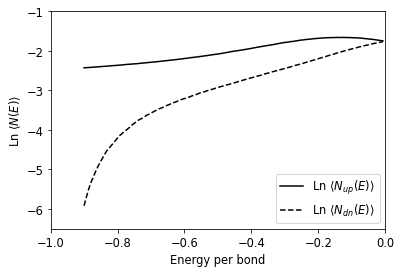

In [22]:
plt.plot(E_vals/3000, np.log(Nup_avg),'k-', label=r'Ln $\langle N_{up}(E)\rangle$')
plt.plot(E_vals/3000, np.log(Ndown_avg),'k--', label=r'Ln $\langle N_{dn}(E)\rangle$')
plt.ylabel(r'Ln $\langle N(E)\rangle$')
plt.xlabel(r'Energy per bond')
plt.ylim([-6.5, -1])
plt.xlim([-1, 0])
plt.legend(loc='lower right')
# plt.savefig('Log.jpg',bbox_inches='tight')

Text(0, 0.5, '$\\beta(E)$')

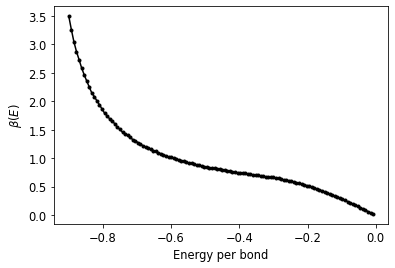

In [23]:
beta_muC = 1/DeltaE_fix * np.log(Nup_avg/Ndown_avg)
plt.plot(E_vals/3000, beta_muC,'k.-')
plt.xlabel(r'Energy per bond')
plt.ylabel(r'$\beta(E)$')
# plt.savefig('beta.jpg',dpi=400,bbox_inches='tight')

In [24]:
# @nb.njit()
# def beta_BHM(DeltaE_fix, Nup, Ndown):
#     n = Nup.shape[0]
#     beta = 0.01*np.ones(n)
#     for i in prange(n):
#         if Nup[i] == 0:
#             beta[i] = 1/1.44
#             print('lol')
#         else:
#             beta[i] = 1/DeltaE_fix * np.log(Nup[i]/Ndown[i])
#     return beta

Text(0, 0.5, '$S = \\ln g(E)$')

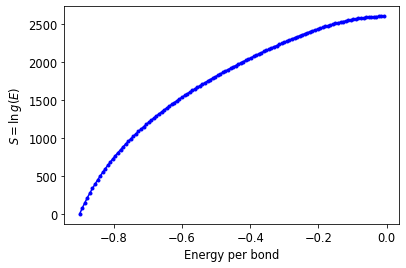

In [25]:
plt.plot(E_vals/3000, entropy,'b.-')
plt.xlabel(r'Energy per bond')
plt.ylabel(r'$S = \ln g(E)$')

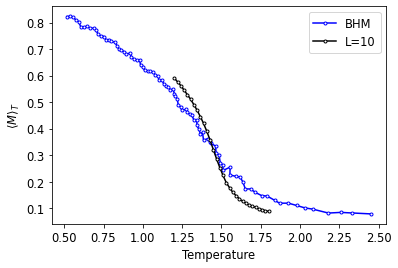

In [26]:
T = 1/beta_muC
vals = (T >= 0.5) & (T <= 2.52)
T = T[vals]
M_BHM = Thermo_avg[:,0]
M_BHM = M_BHM[vals]
plt.plot(T, M_BHM,'b.-',mfc='w',label="BHM")
plt.plot(T_vals, Thermo_W[:,0],'k.-',mfc='w',label='L={}'.format(L))
plt.xlabel('Temperature')
plt.ylabel(r'$\langle M\rangle_T$')
plt.legend()

## BHM-M: Broad Histogram Method using canonical sampling

### STEPS

1. Sample at many temperatures, usually (T, T-3s, T+3s) though other options are possible.
2. Generate (2400) samples using Wolff Clusters.
3. For each sample store in the histogram (same, not a different one) the vals of Nup, Ndown, Visits(E), Thermodynamic quantities, etc.

Let's goooo.

In [27]:
def BHM_M(L, T, n_samples, n_flips, DeltaEb, DeltaE_fix):
    """Broad histogram method using Metropolis-like sampling
    Args:
        L (array)
        nbr (array)
        T (float): Temperature > 0
        n_samples (int): Number of values to calculate
    Returns:
        M (float): Magnetization
    """
    S = random_initialize(L)
    nbr = get_neighbors(L)
    S,_,_ = cluster_sample(S, nbr, T, 3000)
    N_UpDown = np.zeros((n_samples, 2))
    Thermo = np.zeros((n_samples, 2))
    for i in tq(range(n_samples)):
        S, E, M = cluster_sample(S, nbr, T, 10)
        if M==0: print('M = 0 for E =', E)
        Thermo[i,:] = (E, M)
        Emin = E - DeltaEb/2
        Emax = E + DeltaEb/2
        N_UpDown[i,0], N_UpDown[i,1] = get_N_UpDown(S, nbr, E, Emin, Emax, DeltaE_fix, 0, 0)
    return S, N_UpDown, Thermo

In [28]:
# First, define the temperatures to use Tc = 1.444
L = 10
Tc = 1.444
n_samples = 15000
n_flips = 10
DeltaEb = 2
DeltaE_fix = 2
S, N_UpDown1, Thermo1 = BHM_M(L, Tc, n_samples, n_flips, DeltaEb, DeltaE_fix)

  0%|          | 0/15000 [00:00<?, ?it/s]

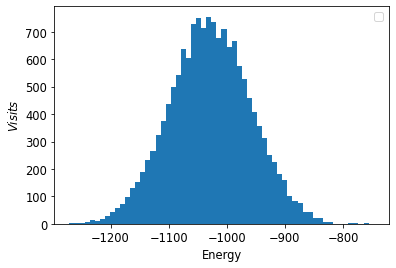

In [29]:
# plt.hist(Thermo1[:,0],label='m')
plt.hist(Thermo1[:,0],bins = 60)
# plt.hist(Thermo1[:,2],label='Xm')
plt.xlabel('Energy')
plt.ylabel(r'$Visits$')
plt.legend()

In [30]:
def histogram(N_UpDown, Thermo, DeltaE):
    Emin = np.min(Thermo[:,0])
    Emax = np.max(Thermo[:,0])
    bins = int((Emax-Emin)/DeltaE)
    n_samples = Thermo.shape[0]
    BHM_array = np.zeros((bins, 8))
    Nup = N_UpDown[:,0]
    Ndown = N_UpDown[:,1]
    E_visits, E_values = np.histogram(Thermo[:,0], bins)
    belong = np.digitize(Thermo[:,0], E_values, right=True)
    E_values = E_values[:-1] + DeltaE
    BHM_array[:,0] = E_values # Energies
    BHM_array[:,1] = E_visits # Visits per energy
    num_trues_T = 0
    for i in range(n_samples):
        index = belong[i]-1
        if index==-1: index = 0
        BHM_array[index, 2] += Thermo[i,0] # Energy
        BHM_array[index, 3] += Thermo[i,0]**2 
        BHM_array[index, 4] += Thermo[i,1] # Magnetization
        BHM_array[index, 5] += Thermo[i,1]**2
        BHM_array[index, 6] += Nup[i]
        BHM_array[index, 7] += Ndown[i]
    null_list = []
    for ii in range(bins):
        if BHM_array[ii,1] != 0: BHM_array[ii,2:] /=  BHM_array[ii,1]
        else: null_list.append(ii)
    BHM_array = np.delete(BHM_array, null_list, axis=0) # Delete empty slots
    return BHM_array
BHM_TC = histogram(N_UpDown1, Thermo1, 3)

In [31]:
Nup_Tc, Ndown_Tc = BHM_TC[:,6], BHM_TC[:,7]
E_vals_Tc = BHM_TC[:,0]
Visits_Tc = BHM_TC[:,1]
beta_M_Tc = 1/DeltaE_fix * np.log(Nup_Tc/Ndown_Tc)
T_Tc = 1/beta_M_Tc
entropy_Tc = DoS(E_vals_Tc, beta_M_Tc)

Text(0, 0.5, '$S = \\ln g(E)$')

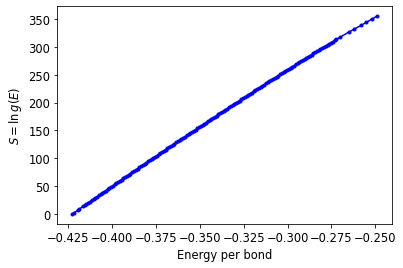

In [32]:
plt.plot(E_vals_Tc/3000, entropy_Tc,'b.-')
plt.xlabel(r'Energy per bond')
plt.ylabel(r'$S = \ln g(E)$')

In [33]:
# Determine Delta T =  1 sigma
popt, pcov = curve_fit(gaussian, T_Tc,  Visits_Tc)
mu_T = abs(popt[1])
sigma_T = abs(popt[2])
print('mu_T =', mu_T)
print('sigma_T =', sigma_T)

mu_T = 1.4434527263693862
sigma_T = 0.04140734685371677


In [34]:
T2 = Tc + sigma_T
T3 = Tc - sigma_T
T4 = Tc + 2*sigma_T
T5 = Tc - 2*sigma_T
T6 = Tc + 3*sigma_T
T7 = Tc - 3*sigma_T
n_samples = 15000
n_flips = 10
DeltaEb = 1
DeltaE_fix = 1
S, N_UpDown2, Thermo2 = BHM_M(L, T2, n_samples, n_flips, DeltaEb, DeltaE_fix)
S, N_UpDown3, Thermo3 = BHM_M(L, T3, n_samples, n_flips, DeltaEb, DeltaE_fix)
S, N_UpDown4, Thermo4 = BHM_M(L, T4, n_samples, n_flips, DeltaEb, DeltaE_fix)
S, N_UpDown5, Thermo5 = BHM_M(L, T5, n_samples, n_flips, DeltaEb, DeltaE_fix)
S, N_UpDown6, Thermo6 = BHM_M(L, T6, n_samples, n_flips, DeltaEb, DeltaE_fix)
S, N_UpDown7, Thermo7 = BHM_M(L, T7, n_samples, n_flips, DeltaEb, DeltaE_fix)
N_UpDown = np.concatenate((N_UpDown1,N_UpDown2,N_UpDown3, N_UpDown4,
                           N_UpDown5, N_UpDown6, N_UpDown7))
Thermo = np.concatenate((Thermo1, Thermo2, Thermo3, Thermo4,
                        Thermo5, Thermo6, Thermo7))

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

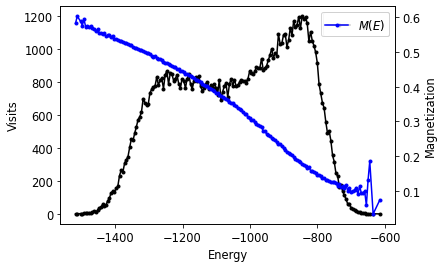

In [35]:
BHM_WOLFF = histogram(N_UpDown, Thermo, 5)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

Visits =  BHM_WOLFF[:,1] # Vistis
E = BHM_WOLFF[:,0] # Energy <E>
E2 = BHM_WOLFF[:,3] # <E^2>
M = BHM_WOLFF[:,4] # Magnetization <M>
M2 = BHM_WOLFF[:,5] # <M^2>
Nup = BHM_WOLFF[:,6] # N_up
Ndown = BHM_WOLFF[:,7] # N_down

ax1.plot(E, Visits, 'k.-',label=r'$V(E)$')
ax2.plot(E, M, 'b.-',label=r'$M(E)$')
ax1.set_ylabel('Visits')
ax2.set_ylabel('Magnetization')
ax1.set_xlabel('Energy')
ax1.legend()
ax2.legend()

## Plotting

Text(0, 0.5, '$\\beta(E)$')

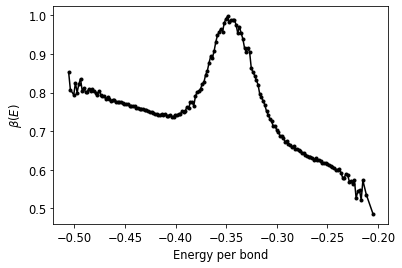

In [36]:
beta_M_BHM = 1/DeltaE_fix * np.log(Nup/Ndown)
T_BHM = 1/beta_M_BHM
entropy_BHM = DoS(E, beta_M_BHM)

plt.plot(E/3000, beta_M_BHM,'k.-')
plt.xlabel(r'Energy per bond')
plt.ylabel(r'$\beta(E)$')

Text(0, 0.5, '$S = \\ln g(E)$')

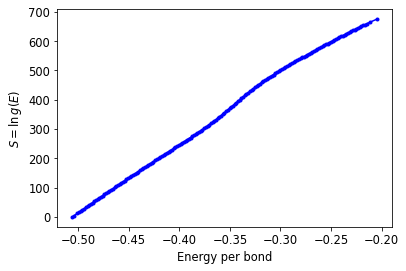

In [37]:
plt.plot(E/3000, entropy_BHM,'b.-')
plt.xlabel(r'Energy per bond')
plt.ylabel(r'$S = \ln g(E)$')

Text(0, 0.5, '$C_v$ per site')

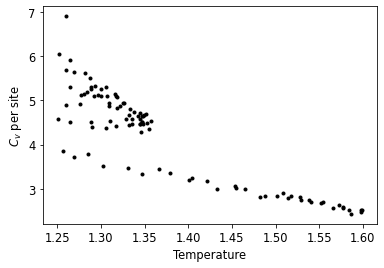

In [38]:
COND = (T_BHM<1.6) & (T_BHM>1.25) # condition for temperatures, just for plotting
T_plot = T_BHM[COND]
Cv_plot =  (E2[COND]-E[COND]**2)/T_plot/L**3
plt.plot(T_plot, Cv_plot ,'k.')
plt.xlabel('Temperature')
plt.ylabel(r'$C_v$ per site')

Text(0, 0.5, '$\\langle M\\rangle$')

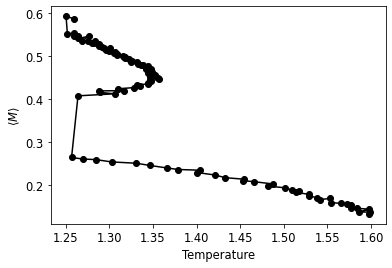

In [39]:
plt.plot(T_plot, M[COND] ,'ko-')
plt.xlabel('Temperature')
plt.ylabel(r'$\langle M\rangle$')